<a href="https://colab.research.google.com/github/ichakraborty/simulation/blob/main/SIMulation_elderly_policy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set-up and data importation

In [ ]:
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import math 
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix as csr
from sklearn.decomposition import NMF
import itertools
import re
import random
import pandas as pd

Getting Data sets:
The commented ones gave us access to some European data, which the model was not ultiamtely trained on.

In [ ]:
!wget https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv
!wget https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv
!wget https://raw.githubusercontent.com/ichakraborty/simulation/main/StateDatabySeason60_5958.csv
# !wget https://raw.githubusercontent.com/ichakraborty/simulation/main/ECDC_surveillance_data_Influenza-1.csv
!wget https://raw.githubusercontent.com/ichakraborty/simulation/main/WHO_NREVSS_Clinical_Labs_states.csv
!wget https://raw.githubusercontent.com/ichakraborty/simulation/main/nst-est2019-01.csv
#!wget https://github.com/ichakraborty/simulation/blob/main/ox_all.csv.zip
#!unzip ox_all.csv.zip


--2021-05-28 00:06:11--  https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16497534 (16M) [text/plain]
Saving to: ‘OxCGRT_US_latest.csv.2’

OxCGRT_US_latest.cs 100%[===================>]  15.73M  --.-KB/s    in 0.1s    

2021-05-28 00:06:11 (149 MB/s) - ‘OxCGRT_US_latest.csv.2’ saved [16497534/16497534]

--2021-05-28 00:06:11--  https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

In [ ]:
all_pol = pd.read_csv('OxCGRT_latest.csv')
us_pol = pd.read_csv('OxCGRT_US_latest.csv')
us_flu =  pd.read_csv('StateDatabySeason60_5958.csv')
#eu_flu =  pd.read_csv('ECDC_surveillance_data_Influenza-1.csv')
#all_pol=  pd.read_csv('ox_all.csv')
us_pop = pd.read_csv('nst-est2019-01.csv')
us_flu_nums = pd.read_csv('WHO_NREVSS_Clinical_Labs_states.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Aggregating US flu numbers

In [ ]:
us_flu_nums = us_flu_nums[us_flu_nums['TOTAL SPECIMENS'] != 'X']
us_flu_nums['TOTAL A'] = pd.to_numeric(us_flu_nums['TOTAL A'])
us_flu_nums['TOTAL B'] = pd.to_numeric(us_flu_nums['TOTAL B'])
us_flu_nums

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,States,Alabama,2018,40,455,2,2,0.88,0.44,0.44
2,States,Arizona,2018,40,183,0,0,0,0,0
3,States,Arkansas,2018,40,86,1,0,1.16,1.16,0
4,States,California,2018,40,409,2,1,0.73,0.49,0.24
5,States,Colorado,2018,40,366,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6844,States,Vermont,2021,19,91,1,0,1.1,1.1,0
6845,States,Virginia,2021,19,178,0,0,0,0,0
6846,States,Washington,2021,19,284,0,0,0,0,0
6847,States,West Virginia,2021,19,145,0,0,0,0,0


In [ ]:
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')
us_pop['2019'] = us_pop['2019'].apply(locale.atof)

In [ ]:
us_pop['2019'] = us_pop['2019'].astype(int)

In [ ]:
us_flu = us_flu_nums

#Data Pre-processing



Dropping n/a values in masking policies (these are scaled 1-4)


In [ ]:
elderly = us_pol[['RegionName','H8_Protection of elderly people','StringencyIndex', 'Date']]


In [ ]:
eld_clean = elderly.dropna()
eld_clean


,RegionName,H8_Protection of elderly people,StringencyIndex,Date
513,Alaska,0.0,0.00,20200101
514,Alaska,0.0,0.00,20200102
515,Alaska,0.0,0.00,20200103
516,Alaska,0.0,0.00,20200104
517,Alaska,0.0,0.00,20200105
...,...,...,...,...
26667,Wyoming,1.0,37.96,20210519
26668,Wyoming,1.0,37.96,20210520
26669,Wyoming,1.0,26.85,20210521
26670,Wyoming,1.0,26.85,20210522


Dropping 2004-2018-week-40 data (this is not generalized and prob should be) 

Encoding flu activity level

Isolating State Data

(The commented out parts are where we were experimenting with different groups of states based on political leadership; this is not actually included in the final model)

In [ ]:
us_flu = us_flu.rename(columns = {'REGION':'STATENAME'})
ia= us_flu[us_flu['STATENAME']=='Iowa']#
ca = us_flu[us_flu['STATENAME']=='California']
ny = us_flu[us_flu['STATENAME']=='New York']
ma = us_flu[us_flu['STATENAME']=='Massachusetts']#
tn = us_flu[us_flu['STATENAME']=='Tennessee']

fl = us_flu[us_flu['STATENAME']=='Florida']#
tx = us_flu[us_flu['STATENAME']=='Texas']#
wa = us_flu[us_flu['STATENAME']=='Washington']#
la = us_flu[us_flu['STATENAME']=='Louisiana']
#
nm = us_flu[us_flu['STATENAME']=='New Mexico']#

az = us_flu[us_flu['STATENAME']=='Arizona']
ut = us_flu[us_flu['STATENAME']=='Utah']
co = us_flu[us_flu['STATENAME']=='Colorado'] #
nv = us_flu[us_flu['STATENAME']=='Nevada']
og = us_flu[us_flu['STATENAME']=='Oregon']#

mn = us_flu[us_flu['STATENAME']=='Maine']#
nc = us_flu[us_flu['STATENAME']=='North Carolina']#
sc = us_flu[us_flu['STATENAME']=='South Carolina']
nd = us_flu[us_flu['STATENAME']=='North Dakota']
sd = us_flu[us_flu['STATENAME']=='South Dakota']#

wy = us_flu[us_flu['STATENAME']=='Wyoming']
ct = us_flu[us_flu['STATENAME']=='Connecticut']
nj = us_flu[us_flu['STATENAME']=='New Jersey']
nh = us_flu[us_flu['STATENAME']=='New Hampshire']#
vt = us_flu[us_flu['STATENAME']=='Vermont']#

ky = us_flu[us_flu['STATENAME']=='Kentucky']#
al = us_flu[us_flu['STATENAME']=='Alabama']
ga = us_flu[us_flu['STATENAME']=='Georgia']
ms = us_flu[us_flu['STATENAME']=='Mississippi']
ks = us_flu[us_flu['STATENAME']=='Kansas']

nb = us_flu[us_flu['STATENAME']=='Nebraska']#
id = us_flu[us_flu['STATENAME']=='Indiana']
il = us_flu[us_flu['STATENAME']=='Illinois']#
mi = us_flu[us_flu['STATENAME']=='Michigan']
wi = us_flu[us_flu['STATENAME']=='Wisconsin']#

misu = us_flu[us_flu['STATENAME']=='Missouri']#
ok = us_flu[us_flu['STATENAME']=='Oklahoma']
mt = us_flu[us_flu['STATENAME']=='Montana']
ih = us_flu[us_flu['STATENAME']=='Idaho']
min = us_flu[us_flu['STATENAME']=='Minnesota']#

va = us_flu[us_flu['STATENAME']=='Virginia']
wv = us_flu[us_flu['STATENAME']=='West Virginia']
md = us_flu[us_flu['STATENAME']=='Maryland']
de = us_flu[us_flu['STATENAME']=='Delaware'] #
oh = us_flu[us_flu['STATENAME']=='Ohio']#

pa = us_flu[us_flu['STATENAME']=='Pennsylvania']
ri = us_flu[us_flu['STATENAME']=='Rhode Island']#
hi = us_flu[us_flu['STATENAME']=='Hawaii']#
ak = us_flu[us_flu['STATENAME']=='Alaska'] #
ar = us_flu[us_flu['STATENAME']=='Arkansas'] #



state_list = [ia, ca, ny, ma, tn, fl, tx, wa, la, nm, az, ut, co, nv, og, nm, nc, sc, nd, sd, wy, ct, nj, nh, vt, ky, al, ga, ms, ks, nb, id, 
              il, mi, wi, misu, ok, mt, ih, min, va, wv, md, de, oh, pa, ri, hi, ak, ar]
states = ["Iowa", "California", "New York", "Massachusetts", "Tennessee", "Florida", "Texas", "Washington", "Louisiana", "New Mexico", "Arizona", "Utah", "Colorado", "Nevada", "Oregon",
          "Maine", "North Carolina", "South Carolina", "North Dakota", "South Dakota", "Wyoming", "Connecticut", "New Jersey", "New Hampshire", "Vermont", "Kentucky", "Alabama", "Georgia",
          "Mississippi", "Kansas", "Nebraska", "Indiana", "Illinois", "Michigan", "Wisconsin", "Missouri", "Oklahoma", "Montana", "Idaho","Minnesota", 
          "Virginia", "West Virginia", "Maryland", "Delaware", "Ohio", "Pennsylvania", "Rhode Island", "Hawaii", "Alaska", "Arkansas"]


# state_list = [ ca, ny, ma, wa, co, ct, nj, nh, vt, il,  md, de, pa, ri, hi]
# states = [ "California", "New York", "Massachusetts", "Washington", "Colorado", "Connecticut", "New Jersey", "New Hampshire", "Vermont", "Illinois", 
#           "Maryland", "Delaware", "Pennsylvania", "Rhode Island", "Hawaii"]



# state_list = [ tn, fl, tx, nc, sc, nd, sd, ky, al, ga, ms, ks, nb, id]
# states = ["Tennessee", "Florida", "Texas",  "North Carolina", "South Carolina", "North Dakota", "South Dakota",  "Kentucky", "Alabama", "Georgia",
#           "Mississippi", "Kansas", "Nebraska", "Idaho"]


# state_list = [ tn]
# states = ["Tennessee"]


          

Dropping unnecessary dates in masking data (mostly to make first day line up with beginning of week 1 in 2020 (jan 4)) 


In [ ]:
elderly = us_pol[['RegionName','H8_Protection of elderly people','StringencyIndex', 'Date']]
eld_clean = elderly.dropna()


eld_pol = eld_clean


# droping any data with date before Jan. 4th 2020
eld_pol = eld_pol.drop(eld_clean[(eld_clean.Date < 20200104)].index)



#Getting week numbers to align 

The flu data is weekly and masking data is daily, so we take 7-day averages of masking data in each region


In [ ]:
eld_all = [] # these two will hold arrays for each state 
si_all=[]
for item in states:
  state_eld= eld_pol[(eld_pol['RegionName']== item)]

  eld  = list(state_eld["H8_Protection of elderly people"])
  si_vals  = list(state_eld["StringencyIndex"])

  eld_all.append(eld)
  si_all.append(si_vals)

#Creating aggregate input data set of week, masking policy, stringency index 

Engineer data from 2018-week-40 to 2020-week-1 of no masking, no stringency 

(there were 64 weeks in this period)

In [ ]:
#creating 0 masking policy data
aug_x = []
for i in range(0, 65):
  for j in range(0,7):
    day = ((7*i)+j + 279) % 366 # unsure of this 279 number 
    aug_x.append([math.cos(2*math.pi*day/365),math.sin(2*math.pi*day/365), 0.0,0.0])
print(aug_x)


[[0.0902516100310407, -0.9959189961471792, 0.0, 0.0], [0.10738134666416306, -0.994217906893952, 0.0, 0.0], [0.12447926388678869, -0.9922222094179324, 0.0, 0.0], [0.141540295217043, -0.989932495087353, 0.0, 0.0], [0.15855938510313475, -0.9873494423939864, 0.0, 0.0], [0.17553149042142777, -0.9844738167520923, 0.0, 0.0], [0.19245158197082995, -0.9813064702716093, 0.0, 0.0], [0.20931464596304888, -0.9778483415056568, 0.0, 0.0], [0.22611568550828803, -0.9741004551724206, 0.0, 0.0], [0.2428497220959358, -0.970063921851507, 0.0, 0.0], [0.25951179706979943, -0.965739937654855, 0.0, 0.0], [0.27609697309746883, -0.9611297838723007, 0.0, 0.0], [0.2926003356333479, -0.9562348265919058, 0.0, 0.0], [0.30901699437494723, -0.9510565162951536, 0.0, 0.0], [0.3253420847119795, -0.9455963874271428, 0.0, 0.0], [0.341570769167856, -0.9398560579418953, 0.0, 0.0], [0.35769823883312546, -0.9338372288229252, 0.0, 0.0], [0.3737197147904692, -0.9275416835791965, 0.0, 0.0], [0.38963044953078774, -0.920971287716634

In [ ]:
all_x= []
all_y= []
summed_201819= np.zeros(365)
count = 0 
for i in range(len(states)):
  temp = []
  state_flu_pd = state_list[i]
  flu_data = list(state_flu_pd["TOTAL A"] + state_flu_pd["TOTAL B"])
  state_name = states[i]
  state_pop = us_pop['2019'].where(us_pop['Geographic Area'] == state_name).dropna().values[0]

  #getting data for specific state 
  eld_level = eld_all[i]
  si_level = si_all[i]

  for k in range(len(aug_x)):
    temp.append(aug_x[k] + [state_pop])
  for j in range(len(eld_level)):
    if( not ( (math.isnan(eld_level[j])) | (math.isnan(si_level[j]))) ):
      # starts on 4th day of year
      day = (j+4)%366
      temp.append([math.cos(2*math.pi*day/365), math.cos(2*math.pi*day/365), eld_level[j], si_level[j], state_pop ])

  flu_data_extended = []
  for item in flu_data:
    for f in range(0,7):
      flu_data_extended.append(item)
  a = len(temp)
  b = len(flu_data_extended)

  if(a < b):
    all_x += temp[:a]
    all_y+= flu_data_extended[:a]
  else:
    all_x += temp[:b]
    all_y+= flu_data_extended[:b]
  
  if(len(flu_data_extended) > 365+180):
    count += 1
    for f in range(0, 365):
        summed_201819[f] = summed_201819[f] + flu_data_extended[f+180]


for i in range(len(summed_201819)):
  summed_201819[i] = summed_201819[i]/count

Creating aggregate output data set of flu level. reverse some state lists because the given data list is out of order 



In [ ]:
print(len(all_x))
print(len(all_y))

40137
40137


#Trying out on differnt models and getting error values


XGB


[00:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9064141717646855


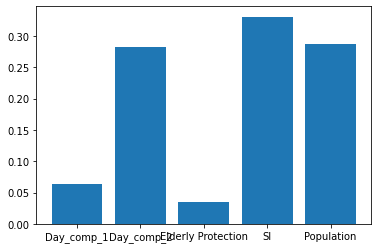

In [ ]:
from sklearn import *
import xgboost
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing


X = np.asarray(all_x)
Y = np.asarray(all_y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
xgb = XGBRegressor( max_depth=8, eta = 0.1)
xgb.fit(X_train, Y_train)

pred = xgb.predict(X_test)
err = r2_score(Y_test,pred)
print(err)


model = xgb
features = ["Day_comp_1","Day_comp_2", "Elderly Protection", "SI", "Population"]
f_importance = model.feature_importances_

pyplot.bar(features,f_importance)
pyplot.show()


Decision Tree


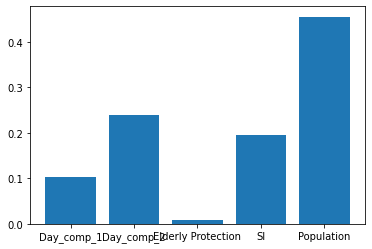

0.8662949012820615


In [ ]:
from sklearn import tree


dt = tree.DecisionTreeRegressor(max_depth= 12)
dt.fit(X_train, Y_train)

pred_dt= dt.predict(X_test)
err_dt = r2_score(Y_test,pred_dt)


model = dt
features = ["Day_comp_1","Day_comp_2", "Elderly Protection", "SI", "Population"]
f_importance = model.feature_importances_

pyplot.bar(features,f_importance)
pyplot.show()
print(err_dt)


Random Forest


0.923950741451808


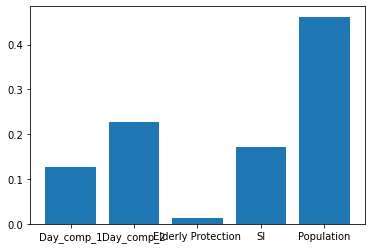

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rf = RandomForestRegressor(max_depth = 25, min_samples_leaf = 4 )

rf.fit(X_train, Y_train)

pred_rf= rf.predict(X_test)
err_rf = r2_score(Y_test,pred_rf)
print(err_rf)


model = rf
features = ["Day_comp_1","Day_comp_2", "Elderly Protection", "SI", "Population"]
f_importance = model.feature_importances_

pyplot.bar(features,f_importance)
pyplot.show()

LGBM


0.9261212873900617


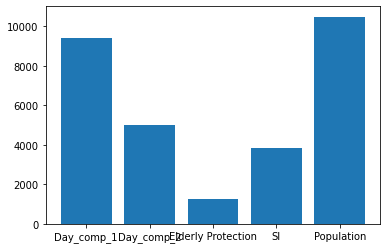

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgbm = LGBMRegressor(n_estimators = 1000, max_depth = 12)
lgbm.fit(X_train, Y_train)

pred_lgbm= lgbm.predict(X_test)
err_lgbm = r2_score(Y_test,pred_lgbm)
print(err_lgbm)


model = lgbm
features = ["Day_comp_1","Day_comp_2", "Elderly Protection", "SI", "Population"]
f_importance = model.feature_importances_

pyplot.bar(features,f_importance)
pyplot.show()

Adaboost


0.9261212873900617


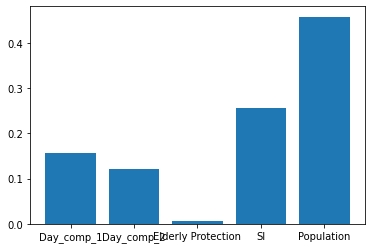

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(n_estimators = 1000, loss = 'square')
ab.fit(X_train, Y_train)

pred_ab= ab.predict(X_test)
err_ab = r2_score(Y_test,pred_lgbm)
print(err_ab)


model = ab
features = ["Day_comp_1","Day_comp_2", "Elderly Protection", "SI", "Population"]
f_importance = model.feature_importances_

pyplot.bar(features,f_importance)
pyplot.show()


Stacked (XGB, LGBM, RF)

In [ ]:
#stacking lgbm and xgb and rf 

from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression

estimators = [ 
    ('xgb',  XGBRegressor(max_depth=8, eta = 0.1)),
    ('rf', RandomForestRegressor(max_depth = 25, min_samples_leaf = 4 )),
    ('lgbm', LGBMRegressor(n_estimators = 1000, max_depth = 12))
]

clf = StackingRegressor(
    estimators=estimators, final_estimator= rf
    )
    

clf.fit(X_train, Y_train)

pred_clf= clf.predict(X_test)
err_clf = r2_score(Y_test,pred_clf)
print(err_clf)



[00:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9324399298909173


Plotting imitation flu season. Input can be adjusted to get different results.

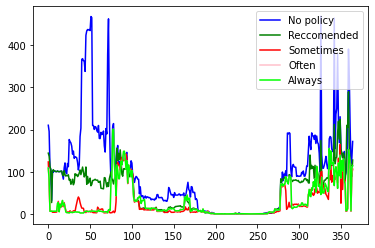

In [ ]:
import matplotlib.pyplot as plt
predictions =[]

for level in range (0, 5):
  x_exp = []
  for i in range(0, 365):
    x_exp.append([math.cos(2*math.pi*(i)/365), math.sin(2*math.pi*(i)/365), level,  75.0, 328239523])
  predictions.append(np.asarray([clf.predict(x_exp)]))

predictions

days = list(range(0, 365, 1))

plt.plot(days, predictions[0].T, color = "blue", label = "No policy ")
plt.plot(days, predictions[1].T, color = "green", label = "Reccomended")
plt.plot(days, predictions[2].T, color = "red",label = "Sometimes" )
plt.plot(days, predictions[4].T, color = "pink", label = "Often")
plt.plot(days, predictions[3].T, color = "lime", label = "Always")


plt.legend(loc="upper right")

plt.show()

Cumulative flu season 2018-19 (USA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


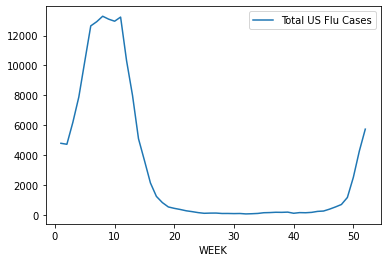

In [ ]:
import matplotlib.pyplot as plt
us_flu_graph = us_flu_nums[(us_flu_nums['YEAR'] == 2018) | ((us_flu_nums['YEAR'] == 2019) & (us_flu_nums['WEEK'] < 40))]
us_flu_graph['TOTAL'] = us_flu_graph['TOTAL A'] + us_flu_graph['TOTAL B']
df = us_flu_graph.groupby('WEEK').agg({'TOTAL': ['sum']})
df.plot(kind = 'line')
plt.legend(["Total US Flu Cases"])

